# Theory

This will be a good basis to make a function of the burst range over the range of frequencies cWB searches.  We are currently looking at the low frequency, short duration search is sensitive between 16-2084 Hz.

The range is calculated (Eq. 30 from reference noted at cell bottom):

\begin{equation}
R_{eff} \approx \Big[ \frac{G}{2\pi^{2}c^{3}} \frac{E_{GW}}{S(f_{0})f_{0}^2\rho_{det}^{2}} \Big]^\frac{1}{2}
\end{equation}

where:

- $S(f_{0})$ is the one-sided noise power spectrum (PSD)
- $f_{0}$ is the central frequency of a narrowband signal
- $\rho_{det}$ is the threshold SNR (detectable) [this willl be determined from the cWB background]
- $E_{GW}$ is the energy emitted in graviational waves

**Reference:**

Sutton, Patrick, _"Rule of Thumb for the Detectability of Gravitational-Wave Bursts"_, arXiv:1304.0210v1, LIGO DCC# [P1000041-v3](https://dcc.ligo.org/LIGO-P1000041/public)

# Input Parameters:

In [1]:
import pdb # pdb.set_trace()  <- to insert breakpooint
import cWBtoolbox as cwb
import datetime
from gwpy.time import to_gps, from_gps
from gwpy.timeseries import TimeSeries
import pandas as pd
import numpy as np
import pickle
import os

#%set_env LIGO_DATAFIND_SERVER=ldr.ldas.cit:80
%matplotlib inline

# define threshold (rate units: 1/yr, prob = (0 1]):
rateThresh = 100

# Define detector:
det = 0 # usually: 0 = L1, 1 = H1, 2 = V1
ifo = cwb.det2ifo(det)

# Specify if this run uses 'online' or 'offline' data:
on_off = 'online'  # O4a can only be processed as 'online' at present!

# Define minimum time for PSD:
minTime = 1200 # 600 for O3, 1200 for O4

# Define plot switch for background plots:
plot = False

# Define reference date:
gps_start = to_gps(datetime.datetime(2023, 7, 10, 0, 0, 0))
gps_start = gps_start.gpsSeconds

# Define time to proces WRT reference time:
startDays = 0
stopDays = startDays+1

# Path the location of predetermined unique segments:
path = '/home/nicole.depergola/jupyter/Nicole/O4a'
# !!!  Make this os.pwd()?

# Select only events that have slag=0 (matches detail file):
select = 'slag == 0'

# Define energy emitted in gravitational waves (for range calculations):
Egw = 1e-8 # solar masses (converted to J later)

# Define frequency range to calulate over:
flo = 32 # was 16 for O3, 32 for O4
fhi = 2048

# Path the veto segments, empty string skips this step:
veto_segs_path = f'{path}/vetoes/{ifo}/VETO_L1_O4A_LOUD-ACTIVE.txt'
#veto_segs_path = './electrical_vetoes_ER15-K01.txt' # for ER15
#veto_segs_path = ''
random_veto = True # True to generate rand veto segments matching those in veto_segs_path
trials = 1500 # must be at least 1 even if random_veto = False, this is ignored if random_veto = False

# Switch to cache PSDs over each day:
savePSD = True
# If there is already an existing cache, this switch will flip to False to avoid overwriting the cache

# Define switch to desplay progress:
verbose = True
if verbose:
    print('|| Input parameters loaded!')

    
# ===================================================================================
# Consistency check the above parameters:

# Make sure that if vetoes are NOT applied, other variable agree with this setting:
if not veto_segs_path:
    random_veto = True # vetoes are not applied, so can't do a random veto run
    trials = 1 # no random veto run, so there only needs to be one pass through the data
    
if not random_veto:
    trials = 1

|| Input parameters loaded!


# Calculate Burst Range:

In [2]:
# Assign ifo string based on det code:
#ifo = cwb.det2ifo(det)  # done in parameter cell above

# It is expected that this will process 1 day, but can process more...
for day in range(startDays,stopDays):
    
    # Is there a file of cached PSDs for the day?
    cachedPSD = False # by default, assume that PSDs need to be calculated from data
    
    # ================================================================= DAILY
    
    # Determine the GPS time for the given day WRT the reference date in gps_start:
    start = gps_start+(day*24*3600)
    stop = start+(24*3600)
    
    # Disable resurrection code:
    startHR = 0 
    rerun = False
    # !!! Remove this when reenabled below.
    
    #events, live, unique, _ = cwb.load_files(start, stop, det, select, path, on_off='online', verbose=True)
    # !!! Use cwb.load_files() here.
    
    # Need this in datetime format to check the run:
    date = from_gps(start)
    #date = from_gps(gps_start) + datetime.timedelta(days=startDays)
    
    if verbose:
        print('\n')
        print(f'*****  Processing date: {from_gps(start)}  *****')
        
    # Determine location of EVENTS file and background (live) file for this time:
    _, eventsfile, livefile = cwb.cwb_files(start, stop, on_off='online')
    
    if verbose:
        print('|| Get cWB daily events...')
    if os.path.exists(eventsfile):
        events = cwb.rdEVENTS(eventsfile)
        # Select desired SLAG:
        events = events.query(select)
    else:
        if verbose:
            print('-> NO DATA FOR THIS DAY.')
            print('----- MOVING TO NEXT DAY -----')
            continue
    if verbose:
        print('-> Done (EVENTS)')
    
    # Get background information from live file:
    if verbose:
        print('|| Get cWB background details (livetime ROOT file)...')
    live_out = f'live-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.csv'
    # !!! Check if live_out exists; import that instead
    live = cwb.rdLiveROOT(livefile, path=path, out_file=live_out, SLAG=0)
    if verbose:
        print('-> Done (livetime)')
    
    # Determine unique segments:
    if verbose:
        print('|| Determining unique background segments...')
    uniqueFile = f'unique-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.txt'
    # !!! Check if uniqueFile exists; import that instead
    unique = cwb.getUnique(live, det, path, outFile=True)
    if verbose:
        print('-> Done (unique background segments)')
        
    if not rerun:
        # Get DQ flags needed for plot segments bar (full day):
        if verbose:
            print('|| Get observing segments...')
        coincFile = f'coinc-{date.year}-{date.month}-{date.day}.p' # filag cache file
        if os.path.exists(coincFile): # load chached files
            saveFlags = pickle.load(open(coincFile, 'rb'))
            flag = saveFlags['flag']
            coincFlag = saveFlags['coincFlag']
        else: # fetch flags and save
            flag, coincFlag = cwb.getFlags(ifo, start, start+(24*3600)) # fetch
            saveFlags = {'flag':flag, 'coincFlag':coincFlag}
            pickle.dump(saveFlags, open(coincFile, 'wb')) # save
        if verbose:
            print('-> Done (observing segments)')
            
        R = [] # define holder variable for the burst range   
        DQflag = [] # initalize DQflag; not produced if no vetos, but saved at the end to it needs to exist or throws an error
    # !!! Check if this is a rerun and allow that
    
    # ================================================================= DAILY
    
    # Veto events if there is a path supplied:
    if veto_segs_path:
        if random_veto:
            if verbose:
                print(f'|| Randomly veto events comparible to using {veto_segs_path}...')
            #events, DQflag = cwb.veto_events(events, veto_segs_path, ifo, random=True, verbose=verbose)
            #_, DQflag = cwb.veto_events(events, veto_segs_path, ifo, verbose)
            #events, DQflag = cwb.rand_veto_events(events, len(DQflag.active), ifo)
        else:
            if verbose:
                print(f'|| Veto events using {veto_segs_path}...')
            #events, DQflag = cwb.veto_events(events, veto_segs_path, ifo, verbose=verbose)
        events, DQflag, _ = cwb.veto_events(events, veto_segs_path, ifo, random=random_veto, coincFlag=coincFlag, trials=trials, verbose=verbose, save=True)
        #pdb.set_trace()
        
    psdFile = f'PSD-{date.year}-{date.month}-{date.day}.p' # file name to cache PSDs for a day
    PSDhold = np.array([]) # initialize varible to hold PSDs to save later
    if os.path.exists(psdFile):
        savePSD = False # don't overwrite the cache file
        psd = pickle.load(open(psdFile, 'rb')) # load chached PSDs
        psd = psd['PSD']
        cachedPSD = True
        
    fname = cwb.mkfname(path, ifo, trials, date, veto_segs_path, random_veto, on_off) # file name to hold daily results
    
    # Loop through each hour in the day:
    for hour in range(startHR, 24):
        # Determine what hour is being worked on:
        if verbose:
            print(f'\n***  HOUR: {hour}  ***')
        hstart = start+(hour*3600) # GPS
        hstop = hstart+3600 
        
        # Determine SNR looking back 1 hour for 10 min segments within hour:
        if verbose:
            print(f'|| Get SNR at thresh rate {rateThresh}/yr...')
        # Look back 1 hour from the END of a 10 minute segment:
        snrStop = hstart + (np.array([1, 2, 3, 4, 5, 6])*600) # GPS
        snrStart = snrStop - 3600 # look back 1 hour
        nten = len(snrStop)
        
        snr = np.zeros([trials,nten]) # there are 6 10-minute segments in an hour
        for k in range(nten):
            if verbose:
                print(f'--- SNR: Looking back 1 hour from {from_gps(snrStop[k])}')
            # !!!  Mike: copy getSNR from cWBtoolbox into a cell above this cell, call it something different, and 
            # make sure to edit your new function to accept a ref. SNR to compare with newly found SNRs.  And breakpoint 
            # when new SNR > ref SNR.
            snr[:,k] = cwb.getSNR(snrStart[k], snrStop[k], rateThresh, det, live, events, unique, plot=plot, verbose=verbose)
            # !!! may want to put ref to coincFlag here to skip out of coincidence segments
            
        if not np.isnan(snr).all():
            if cachedPSD:
                PSD = psd[hour*6:(hour*6)+6,:] # select PSD data for this hour
                FFTlen = 8
                f = np.arange(0, (16384/2)+(FFTlen**-1), (FFTlen**-1))
                # Find indices where f > flo:
                nlo = np.where(f >= flo)
                # find indices where f >= fhi:
                nhi = np.where(f < fhi)
                # Find indecies where f > flo AND f >= fhi:
                ndx = np.intersect1d(nlo,nhi)
                f = f[ndx]
            else:
                # Get full hour of strain data:
                if verbose:
                    print(f'|| Get full hour of strain data...')
                data = TimeSeries.get(f'{ifo}:GDS-CALIB_STRAIN', hstart, hstop, pad=0, verbose=verbose, allow_tape=True)

                # Get PSD in 10 minute intervals:
                if verbose:
                    print(f'|| Get 10 min PSDs for this hour...')
                PSD, f, flagStat = cwb.getPSD(data, ifo, coincFlag, flo=flo, fhi=fhi, verbose=verbose)
                
        else:
            if verbose:
                print(f'|| No SNRs for this hour; skip getting data...')
            FFTlen = 8
            PSDlen = int((16384*(FFTlen/2))+1)
            PSD = np.zeros([nten, PSDlen])
            f = np.arange(0, (16384/2)+(FFTlen**-1), (FFTlen**-1))
            PSD, f = cwb.select_f(PSD, f, flo, fhi)
            
        if savePSD:
            # Add this hour's PSDs to the full day's PSDs:
            if len(PSDhold) == 0:
                PSDhold = PSD
            else:
                PSDhold = np.vstack([PSDhold, PSD])
        
        # The burst range calculations needs SNR and what cWB reports is SNR**2:
        snr = np.sqrt(snr)
        # Caluclate R WRT frequency for each 10 min segment:
        if verbose:
            print(f'|| Calulate burst range...')
        if trials == 1: # no random veto trials
            SNR = snr[0]
            if len(R) == 0: # if this is the first 10 min, then fill R with the range array (establish number of columns)
                R = cwb.brange(PSD, f, SNR, Egw)
            else: # if number of columns in R is established, then append rows to it
                R = np.vstack([R, cwb.brange(PSD, f, SNR, Egw)])
        else: # there are multiple random veto trials
            for trial in range(trials): # loop over the trials
                SNR = snr[trial,:] # select the SNRs for this trial
                if len(R) == 0: # if this is the first 10 min, then fill R with the range dict (establish number of columns)
                    R = {str(trial): cwb.brange(PSD, f, SNR, Egw)}
                elif str(trial) in R: # check if a key exists in dict
                    R.update({str(trial): np.vstack([R[str(trial)], cwb.brange(PSD, f, SNR, Egw)])}) # append new values
                else:
                    R[str(trial)] = cwb.brange(PSD, f, SNR, Egw) # create new key for next trial
        
        # Save intermediate results [since Jupyter loves to yeet my buffer :( ]:
        if verbose:
            print(f'|| Save results to file [{fname}]...')
        burstRange = {'R':R, 'f':f, 'flag':flag, 'coincFlag':coincFlag, 'ifo':ifo}
        pickle.dump(burstRange, open(fname, 'wb'))
    # END loop over hours in a day

    # Make plot of range(F,T) with segments bar:
    if verbose:
        print('|| Plot results...')
    T, F, t, meanRange = cwb.plot_brange(R, f, start, ifo, flag, coincFlag, path)
    #nozeros_meanRange = meanRange[meanRange != 0]
    #std = np.std(nozeros_meanRange)
    #N = len(nozeros_meanRange)
    #error = std/np.sqrt(N)
    #txtstr = r'$meanRange = {nozeros_meanRange} \pm {error}$'
    #ax.text(1, 25, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    #T, F, t, meanRange, BNS = cwb.plot_brange(R, f, start, ifo, flag, coincFlag, path)
    
    if savePSD:
        # Cache PSDs for the day
        saveme = {'PSD':PSDhold}
        pickle.dump(saveme, open(f'PSD-{date.year}-{date.month}-{date.day}.p','wb'))

    # Save final results:
    if verbose:
        print(f'|| Save results to file [{fname}]...')
    burstRange = {'R':R, 'T':T, 'F':F, 't':t, 'f':f, 'flag':flag, 'coincFlag':coincFlag, 'ifo':ifo, 'meanRange':meanRange, 'DQflag':DQflag, 'veto_segs_path':veto_segs_path, 'random_veto':random_veto}
    pickle.dump(burstRange, open(fname, 'wb'))
    
    
    #pdb.set_trace() # breakpoint to debug before going on to next day
    
    # To read the pickel file back in:
    #burstRange = pickle.load(open(fname, 'rb'))

# END loop over a single day

if verbose:
    print('----- BURST RANGE CALCULATIONS COMPLETE -----')
# END loop over days



*****  Processing date: 2023-07-12 00:00:00  *****
Run: O4a
|| Get cWB daily events...
-> Done (EVENTS)
|| Get cWB background details (livetime ROOT file)...
-- Loading ROOT file...
-- Slect SLAG...
-- Write selected SLAG to pd.DataFrame...
-- Write livetime data to /home/nicole.depergola/jupyter/Nicole/O4a/live-L1-2023-07-12.csv
-> Done (livetime)
|| Determining unique background segments...
-- Write unique background segments to /home/nicole.depergola/jupyter/Nicole/O4a/L1/unique-L1-2023-7-12.txt
-> Done (unique background segments)
|| Get observing segments...
-> Done (observing segments)
|| Randomly veto events comparible to using /home/nicole.depergola/jupyter/Nicole/O4a/vetoes/L1/VETO_L1_O4A_LOUD-ACTIVE.txt...
/home/nicole.depergola/jupyter/Nicole/O4a/vetoes/L1
-- Simulating random vetoes: 1500 trials
-> Trial 0000 done: 0.01% of events vetoed (N = 1).
/home/nicole.depergola/jupyter/Nicole/O4a/vetoes/L1
-> Trial 0001 done: 0.00% of events vetoed (N = 0).
/home/nicole.depergola/

/cvmfs/software.igwn.org/conda/envs/igwn-py38/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


|| Save results to file [/home/nicole.depergola/jupyter/Nicole/O4a/L1/brange-daily-rvetoed-1500-L1-2023-07-12.p]...

***  HOUR: 3  ***
|| Get SNR at thresh rate 100/yr...
--- SNR: Looking back 1 hour from 2023-07-12 03:10:00
-> background time = 2878800.0
-> zero-lag time = 1200.0
-> SNR = [63. 63. 63. ... 63. 63. 63.]
--- SNR: Looking back 1 hour from 2023-07-12 03:20:00
-> background time = 2878800.0
-> zero-lag time = 1200.0
-> SNR = [63. 63. 63. ... 63. 63. 63.]
--- SNR: Looking back 1 hour from 2023-07-12 03:30:00
-> background time = 2878800.0
-> zero-lag time = 1200.0
-> SNR = [152. 152. 152. ... 152. 152. 152.]
--- SNR: Looking back 1 hour from 2023-07-12 03:40:00
-> background time = 2878800.0
-> zero-lag time = 1200.0
-> SNR = [152. 152. 152. ... 152. 152. 152.]
--- SNR: Looking back 1 hour from 2023-07-12 03:50:00
-> background time = 5757600.0
-> zero-lag time = 2400.0
-> SNR = [132. 132. 132. ... 132. 132. 132.]
--- SNR: Looking back 1 hour from 2023-07-12 04:00:00
-> back

/cvmfs/software.igwn.org/conda/envs/igwn-py38/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


|| Save results to file [/home/nicole.depergola/jupyter/Nicole/O4a/L1/brange-daily-rvetoed-1500-L1-2023-07-12.p]...

***  HOUR: 15  ***
|| Get SNR at thresh rate 100/yr...
--- SNR: Looking back 1 hour from 2023-07-12 15:10:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
--- SNR: Looking back 1 hour from 2023-07-12 15:20:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
--- SNR: Looking back 1 hour from 2023-07-12 15:30:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
--- SNR: Looking back 1 hour from 2023-07-12 15:40:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
--- SNR: Looking back 1 hour from 2023-07-12 15:50:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
--- SNR: Looking back 1 hour from 2023-07-12 16:00:00
-> background time = 0.0
-> zero-lag time = 0.0
-> no events
|| No SNRs for this hour; skip getting data...
|| Calulate burst range...
|| Save results to file [/home/nicole.depergola/jupyter/Nicole/O

# Load random veto results from file (this can take a while!)

In [3]:
# Load parameters above before this cell!

day = 0
date = from_gps(gps_start+(day*24*3600))

'''
#rpath = f'./{ifo}/brange-daily-rvetoed-100-{ifo}-{date.year}-{date.month}-{date.day}.p'
rpath = f'./{ifo}/brange-daily-rvetoed-100-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
#'/home/amber.stuver/Jupyter/brange/H1/brange-daily-rvetoed-H1-2019-11-28.p'
burstRange = pickle.load(open(rpath, 'rb'))
meanRange = burstRange['meanRange']
test = np.mean(meanRange, axis=1)

hold = []
hold = np.append(hold, test)
'''

#rpath = f'./{ifo}/brange-daily-rvetoed-500-{ifo}-{date.year}-{date.month}-{date.day}.p'
rpath = f'./{ifo}/brange-daily-rvetoed-1500-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
burstRange = pickle.load(open(rpath, 'rb'))
meanRange = burstRange['meanRange']
test = np.mean(meanRange, axis=1)

hold = []
hold = np.append(hold, test)

#rpath = f'./{ifo}/brange-daily-rvetoed-2000-{ifo}-{date.year}-{date.month}-{date.day}.p'
rpath = f'./{ifo}/brange-daily-rvetoed-2000-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
burstRange = pickle.load(open(rpath, 'rb'))
meanRange = burstRange['meanRange']
test = np.mean(meanRange, axis=1)

#hold = []
hold = np.append(hold, test)

test = hold

burstRange = []


#vpath = f'./{ifo}/brange-daily-vetoed-{ifo}-{date.year}-{date.month}-{date.day}.p'
vpath = f'./{ifo}/brange-daily-vetoed-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
burstRange = pickle.load(open(vpath, 'rb'))
meanRange = burstRange['meanRange']
trueVeto = np.mean(meanRange, axis=1)


#path = f'./{ifo}/brange-daily-{ifo}-{date.year}-{date.month}-{date.day}.p'
path = f'./{ifo}/brange-daily-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
burstRange = pickle.load(open(path, 'rb'))
meanRange = burstRange['meanRange']
noVeto = np.mean(meanRange, axis=1)

burstRange = []
meanRange = []

## Save just the results we need to a single file for faster reloading later...

In [4]:
meanRange = {'noVeto':noVeto, 'trueVeto':trueVeto, 'test':test}
pickle.dump(meanRange, open(f'./{ifo}/meanRange-rveto-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p', 'wb'))

# Load results to analyze distribution from random vetos to measure significance of result from true veotoes

In [2]:
day = 0
date = from_gps(gps_start+(day*24*3600))

ifo = 'L1'

meanRange = pickle.load(open(f'./{ifo}/meanRange-rveto-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p', 'rb'))
noVeto = meanRange['noVeto']
trueVeto = meanRange['trueVeto']
test = meanRange['test']

## Look at full results (There shouldn't be results below 8.59 kpc! Look into this!)

Bug most likely in cWBtoolbox -> getSNR()

/tmp/ipykernel_1740194/2867222552.py:10: RuntimeWarning: divide by zero encountered in log
  a, b = np.polyfit((fitx)**2, np.log(count[16:]),  1)


The mean range for 3500 trials is 7.591 +/- 1.130e-04 kpc.


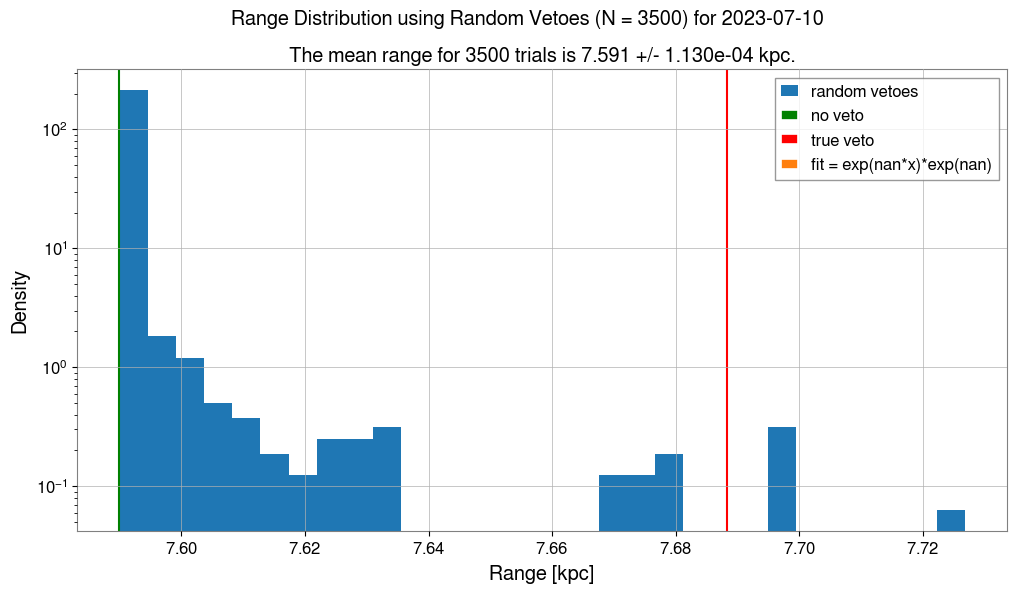

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test, 30, density=True, log=True, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]
fitx = midbins[16:]
#a, b = np.polyfit(fitx, np.log(count[16:]),  1, w=np.sqrt(count[16:]))
a, b = np.polyfit((fitx)**2, np.log(count[16:]),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
fity = np.exp(a*fitx**2) * np.exp(b)

plt.axvline(noVeto, color='g', label='no veto')
plt.axvline(trueVeto, color='r', label='true veto')
plt.plot(fitx, fity, label=f'fit = exp({a:02.2f}*x)*exp({b:0.2f})')
plt.legend()
plt.xlabel('Range [kpc]')
plt.ylabel('Density')
plt.suptitle(f'Range Distribution using Random Vetoes (N = {len(test)}) for {date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}')
mu = np.mean(test)
std = np.std(test)
sterr = std/np.sqrt(len(test))
plt.title(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
         

print(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
plt.savefig(f'./vetoes/{ifo}/range_dist-rvetoes-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.png')

[-2356.853864    4805.36356964]
[ 27.71952629  26.30393909  24.88920161  23.47531285
  22.06227177  20.65007737  19.23872863  17.82822453
  16.41856408  15.00974625  13.60177005  12.19463447
  10.7883385    9.38288114   7.9782614    6.57447827
   5.17153076   3.76941788   2.36813863   0.96769203
  -0.43192292  -1.83070721  -3.22866181  -4.62578772
  -6.02208591  -7.41755737  -8.81220307 -10.20602398
 -11.5990211  -12.99119538]
The mean range for 3500 trials is 7.591 +/- 1.130e-04 kpc.


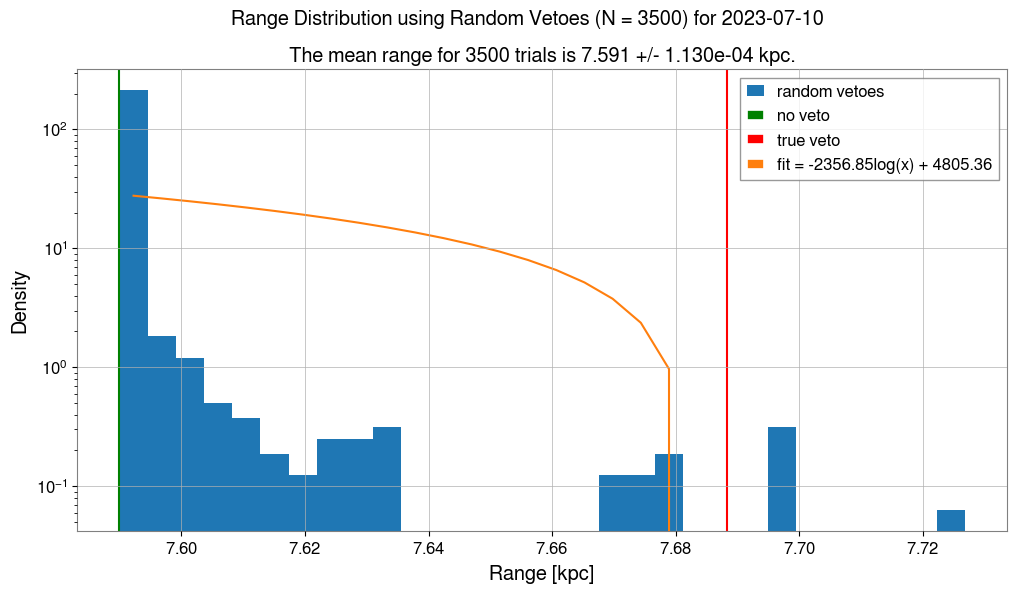

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
from scipy.optimize import curve_fit

plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test, 30, density=True, log=True, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]
fitx = midbins[16:]
#a, b = np.polyfit(fitx, np.log(count[16:]),  1, w=np.sqrt(count[16:]))
#a, b = np.polyfit((fitx)**2, np.log(count[16:]),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
#fity = np.exp(a*fitx**2) * np.exp(b)

fit = np.polyfit(np.log(midbins), count, 1)
print(fit)
fity = fit[0]*np.log(midbins) + fit[-1]
print(fity)

plt.axvline(noVeto, color='g', label='no veto')
plt.axvline(trueVeto, color='r', label='true veto')
plt.plot(midbins, fity, label=f'fit = {fit[0]:0.2f}log(x) + {fit[-1]:0.2f}')
plt.legend()
plt.xlabel('Range [kpc]')
plt.ylabel('Density')
plt.suptitle(f'Range Distribution using Random Vetoes (N = {len(test)}) for {date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}')
mu = np.mean(test)
std = np.std(test)
sterr = std/np.sqrt(len(test))
plt.title(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
         

print(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
#plt.savefig(f'./vetoes/{ifo}/range_dist-rvetoes-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.png')

[-2356.853864    4805.36356964]
[ 27.71952629  26.30393909  24.88920161  23.47531285
  22.06227177  20.65007737  19.23872863  17.82822453
  16.41856408  15.00974625  13.60177005  12.19463447
  10.7883385    9.38288114   7.9782614    6.57447827
   5.17153076   3.76941788   2.36813863   0.96769203
  -0.43192292  -1.83070721  -3.22866181  -4.62578772
  -6.02208591  -7.41755737  -8.81220307 -10.20602398
 -11.5990211  -12.99119538]
The mean range for 3500 trials is 7.591 +/- 1.130e-04 kpc.


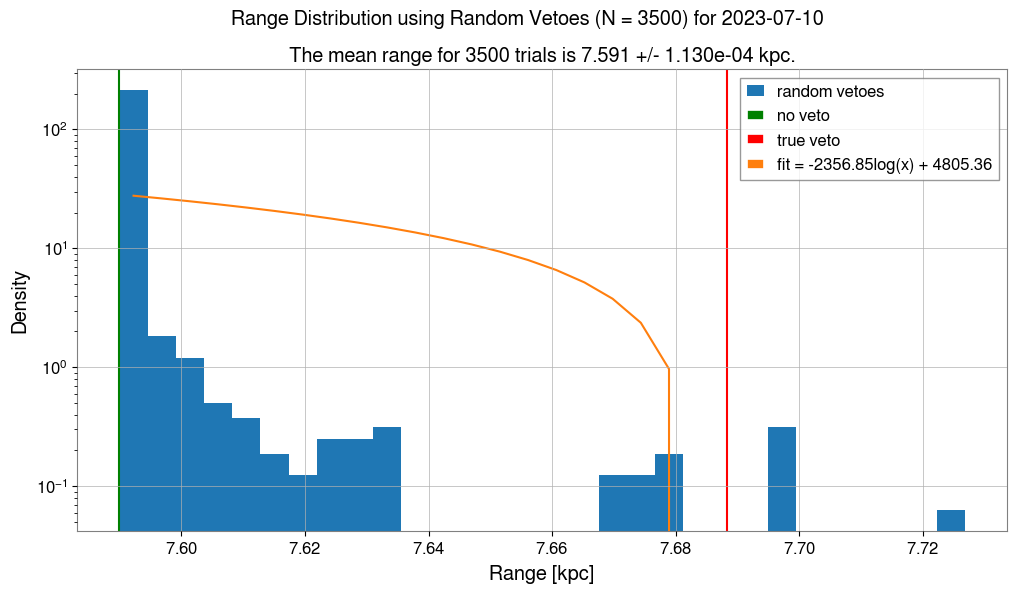

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
from scipy.optimize import curve_fit

plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test, 30, density=True, log=True, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]
fitx = 1/midbins
#a, b = np.polyfit(fitx, np.log(count[16:]),  1, w=np.sqrt(count[16:]))
#a, b = np.polyfit((fitx)**2, np.log(count[16:]),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
#fity = np.exp(a*fitx**2) * np.exp(b)

fit = np.polyfit(np.log(midbins), count, 1)
print(fit)
fity = fit[0]*np.log(midbins) + fit[-1]
print(fity)

plt.axvline(noVeto, color='g', label='no veto')
plt.axvline(trueVeto, color='r', label='true veto')
plt.plot(midbins, fity, label=f'fit = {fit[0]:0.2f}log(x) + {fit[-1]:0.2f}')
plt.legend()
plt.xlabel('Range [kpc]')
plt.ylabel('Density')
plt.suptitle(f'Range Distribution using Random Vetoes (N = {len(test)}) for {date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}')
mu = np.mean(test)
std = np.std(test)
sterr = std/np.sqrt(len(test))
plt.title(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
         

print(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')
#plt.savefig(f'./vetoes/{ifo}/range_dist-rvetoes-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.png')

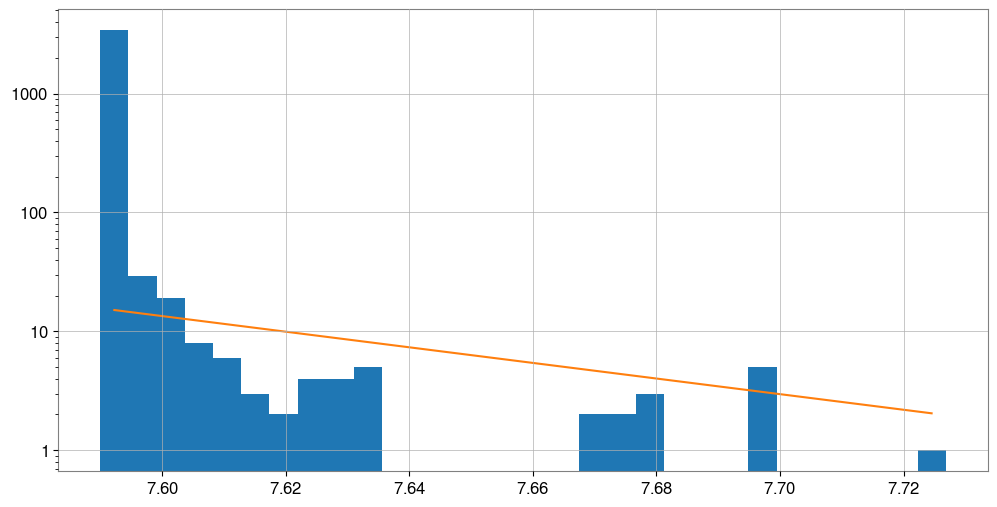

In [28]:
plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test, 30, density=False, log=True, label=f'random vetoes')

P = ss.expon.fit(midbins)
rP = ss.expon.pdf(midbins, *P)
plt.plot(midbins, rP)

In [15]:
X = ss.expon.rvs(loc=0.5, scale=1.2, size=1000)

#MLE
P = ss.expon.fit(X)
P

(0.5024993258564133, 1.1899822660144221)

In [20]:
X

array([4.20616264, 2.46874007, 2.00805587, ..., 1.46970937,
       0.96868853, 3.57762326])

In [16]:
list(count)

[213.40237943244875,
 1.8164570013332018,
 1.1900925181146247,
 0.5010915865745788,
 0.3758186899310073,
 0.18790934496546707,
 0.12527289664366908,
 0.2505457932872894,
 0.2505457932872894,
 0.3131822416091728,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12527289664366908,
 0.1252728966436447,
 0.18790934496546707,
 0.0,
 0.0,
 0.0,
 0.3131822416091728,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06263644832182234]

In [128]:
list(midbins)

[7.592248733726807,
 7.596810203819209,
 7.601371673911611,
 7.6059331440040125,
 7.610494614096415,
 7.615056084188817,
 7.619617554281218,
 7.624179024373619,
 7.628740494466022,
 7.633301964558424,
 7.637863434650825,
 7.642424904743228,
 7.646986374835629,
 7.6515478449280305,
 7.656109315020434,
 7.660670785112835,
 7.665232255205236,
 7.669793725297638,
 7.67435519539004,
 7.678916665482442,
 7.683478135574844,
 7.688039605667246,
 7.692601075759647,
 7.697162545852049,
 7.7017240159444516,
 7.706285486036853,
 7.710846956129254,
 7.715408426221657,
 7.719969896314058,
 7.72453136640646]

In [97]:
s=0
for i in test:
    if i > 7.7:
        s+=1

print(s)

1


(0.500849212670261, 1.1569949094047285)


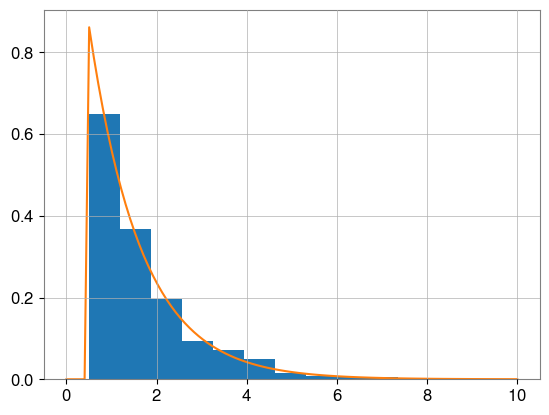

In [13]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

#generate data 
X = ss.expon.rvs(loc=0.5, scale=1.2, size=1000)

#MLE
P = ss.expon.fit(X)
print(P)
#not exactly 0.5 and 1.2, due to being a finite sample


#plotting
rX = np.linspace(0,10, 100)
rP = ss.expon.pdf(rX, *P)
#Yup, just unpack P with *P, instead of scale=XX and shape=XX, etc.


#need to plot the normalized histogram with `normed=True`
plt.hist(X, density=True)
plt.plot(rX, rP)

In [14]:
X

array([4.27050077, 0.60450943, 2.63037003, ..., 1.33311077,
       0.63582047, 0.56221135])

--------

# Debug if needed:

In [6]:
parts = veto_segs_path.split('/') # split at folders
path = '' # empty to append to in loop
            # Loop over each directory:
for z in range(1,len(parts)-1):
    path = path + '/' + parts[z] # assemble path
rootName = veto_segs_path.split('/')[-1].split('.')[0] # extract file name of veto file w/o ext
print(path)
print(rootName)

In [66]:
trials = 1 # because we're not applying vetoes

start = gps_start+(day*24*3600)
hstart = start+(hour*3600)
hstop = hstart+3600 

snrStop = hstart + (np.array([1, 2, 3, 4, 5, 6])*600) # GPS
snrStart = snrStop - 3600 # look back 1 hour
nten = len(snrStop)

snr = np.zeros([trials,nten])
SNR = snr[0]



FFTlen = 8
PSDlen = int((16384*(FFTlen/2))+1)
PSD = np.zeros([nten, PSDlen])
f = np.arange(0, (16384/2)+(FFTlen**-1), (FFTlen**-1))
PSD, f = cwb.select_f(PSD, f, flo, fhi)
            
            
if trials == 1: # no random veto trials
    if len(R) == 0: # if this is the first 10 min, then fill R with the range array (establish number of columns)
        R = cwb.brange(PSD, f, SNR, Egw)
    else: # if number of columns in R is established, then append rows to it
        R = np.vstack([R, cwb.brange(PSD, f, SNR, Egw)])
else:
    for trial in range(trials): # loop over the trials
        SNR = snr[trial,:] # select the SNRs for this trial
        if len(R) == 0: # if this is the first 10 min, then fill R with the range dict (establish number of columns)
            R = {str(trial): cwb.brange(PSD, f, SNR, Egw)}
        elif str(trial) in R: # check if a key exists in dict
            R.update({str(trial): np.vstack([R[str(trial)], cwb.brange(PSD, f, SNR, Egw)])}) # append new values
        else:
            R[str(trial)] = cwb.brange(PSD, f, SNR, Egw)


if type(R) is dict:
    isdict = True
else:
    isdict = False

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py38/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [5]:
day = 0
date = from_gps(gps_start+(day*24*3600))

rpath = f'./{ifo}/brange-daily-rvetoed-{ifo}-{date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}.p'
#'/home/amber.stuver/Jupyter/brange/H1/brange-daily-rvetoed-H1-2019-11-28.p'
burstRange = pickle.load(open(rpath, 'rb'))
meanRange = burstRange['meanRange']
test = np.mean(meanRange, axis=1)


FileNotFoundError: [Errno 2] No such file or directory: './L1/brange-daily-rvetoed-L1-2023-06-04.p'

-----------

## Let's look at just the results we expect and work on the fit and p-value:

Look at a density distribution in log scale...

In [11]:
test = test[test>=noVeto] # eliminate values below noVeto range

plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test2, 1000, density=True, log=False, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]

ndx = np.where(count > 0)
midbins = midbins[ndx]
count = count[ndx]
#fitx = midbins[16:]
fitx = midbins
a, b = np.polyfit(fitx, np.log(count),  1, w=np.sqrt(count))
#a, b = np.polyfit(fitx, np.log(count),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
fity = np.exp(a*fitx) * np.exp(b)

plt.axvline(noVeto, color='g', label='no veto')
plt.axvline(trueVeto, color='r', label='true veto')
plt.plot(fitx, fity, label=f'fit = exp({a:02.2f}*x)*exp({b:0.2f})')
plt.legend()
plt.xlabel('Range [kpc]')
plt.ylabel('Density')
plt.title(f'Range Distribution using Random Vetoes (N = {len(test)}) for {date.year:04.0f}-{date.month:02.0f}-{date.day:02.0f}')
         
mu = np.mean(test)
std = np.std(test)
sterr = std/np.sqrt(len(test))
print(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')

NameError: name 'test2' is not defined

<Figure size 1200x600 with 0 Axes>

In [37]:
rm = np.where(test > noVeto)[0]
test2 = test[rm]
test2

array([8.61823489, 8.64275029, 8.61937554, ..., 8.5952447 ,
       8.62471503, 8.59523673])

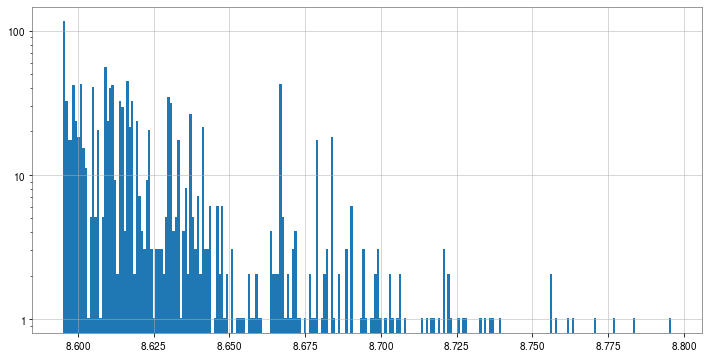

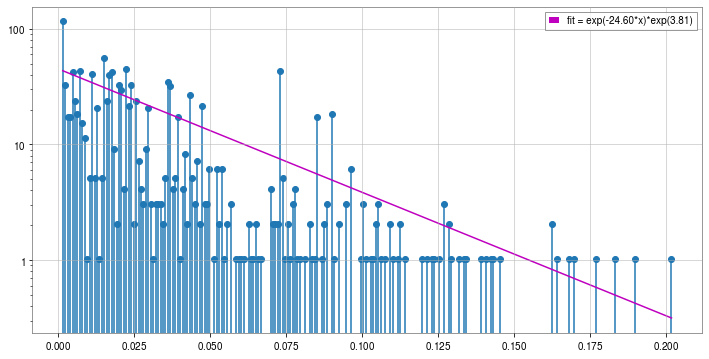

In [51]:
plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test2, 250, density=True, log=True, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]
pow = 1
ndx = np.where(count > 0)
midbins = midbins[ndx]-noVeto
count = count[ndx]
#fitx = midbins[16:]
fitx = midbins
a, b = np.polyfit(fitx**pow, np.log(count),  1, w=np.sqrt(count))
#a, b = np.polyfit(fitx, np.log(count),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
fity = np.exp(a*fitx**pow) * np.exp(b)
plt.figure(figsize=(12,6))
plt.stem(midbins, count)
plt.semilogy(fitx, fity, 'm', label=f'fit = exp({a:02.2f}*x)*exp({b:0.2f})')
plt.legend()

Look at a count distribution in linear scale...

The mean range for 2563 trials is 8.608 +/- 5.207e-04 kpc.


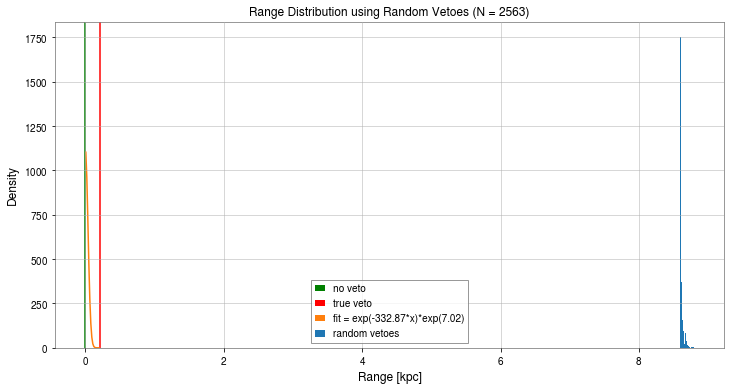

In [13]:
test = test[test>=noVeto]

plt.figure(figsize=(12,6))
count, bins, _ = plt.hist(test, 14, density=False, log=False, label=f'random vetoes')

midbins = (np.diff(bins)/2)+bins[:-1]
#fitx = midbins[16:]
fitx = midbins
a, b = np.polyfit((fitx-noVeto)**2, np.log(count),  1, w=np.sqrt(count)) # less biased
#a, b = np.polyfit(fitx, np.log(count),  1)
# You may run into fitting problems if a bin has no counts in it!  Consider variable bin size?
fity = np.exp(a*(fitx-noVeto)**2) * np.exp(b)

plt.axvline(noVeto-noVeto, color='g', label='no veto')
plt.axvline(trueVeto-noVeto, color='r', label='true veto')
plt.plot(fitx-noVeto, fity, label=f'fit = exp({a:02.2f}*x)*exp({b:0.2f})')
plt.legend()
plt.xlabel('Range [kpc]')
plt.ylabel('Density')
plt.title(f'Range Distribution using Random Vetoes (N = {len(test)})')
         
mu = np.mean(test)
std = np.std(test)
sterr = std/np.sqrt(len(test))
print(f'The mean range for {len(test)} trials is {mu:0.3f} +/- {sterr:0.3e} kpc.')

Calculate the p-value by integrating the fit...

In [38]:
# Calculate the probability:

# Calculate the p-value as the ratio of the fit integrals: (btwn the true veto range to inf.) / (no veto range to inf.)
prob = cwb.integrate_exp_fit(a, b, trueVeto)/cwb.integrate_exp_fit(a, b, noVeto)
print(f'p-value = {prob[0]:0.3e}')

p-value = 3.849e-05


In [2]:
import cWBtoolbox as cwb
select = 'slag >= 0'
cwb.veto_perdiem(ifo, select, veto_segs_path)

2019-11-2:	0.51%
2019-11-3:	0.66%
2019-11-4:	0.58%
2019-11-5:	2.52%
2019-11-6:	1.25%
2019-11-7:	0.52%
2019-11-8:	0.97%
2019-11-9:	0.80%
2019-11-10:	4.63%
2019-11-11:	1.52%
2019-11-12:	0.68%
2019-11-13:	1.81%
2019-11-14:	0.41%
2019-11-15:	6.94%
2019-11-16:	5.26%
2019-11-17:	0.86%
2019-11-18:	0.29%
2019-11-19:	0.59%
2019-11-20:	1.60%
2019-11-21:	0.77%
2019-11-22:	0.37%
2019-11-23:	2.72%
2019-11-24:	2.71%
2019-11-25:	1.46%
2019-11-26:	3.15%
2019-11-27:	3.68%
2019-11-28:	4.48%
2019-11-29:	0.36%
2019-11-30:	0.40%
2019-12-1:	6.79%
2019-12-2:	5.13%
2019-12-3:	1.03%
2019-12-4:	0.83%
2019-12-5:	1.29%
2019-12-6:	6.34%
2019-12-7:	0.89%
2019-12-8:	1.76%
2019-12-9:	0.83%
2019-12-10:	0.95%
2019-12-10:	N/A
2019-12-12:	10.01%
2019-12-13:	9.02%
2019-12-14:	5.01%
2019-12-15:	0.89%
2019-12-16:	1.42%
2019-12-16:	N/A
2019-12-16:	N/A
2019-12-19:	1.51%
2019-12-20:	2.44%
2019-12-21:	3.82%
2019-12-22:	3.94%
2019-12-23:	6.03%
2019-12-24:	1.67%
2019-12-25:	1.41%
2019-12-26:	0.86%
2019-12-27:	1.08%
2019-12-28:	1.

In [3]:
%debug

> /home/amber.stuver/Jupyter/brange/cWBtoolbox.py(1380)veto_events()
   1378                 DQflag = dq
   1379 
-> 1380     return EVENTS, DQflag, time
   1381 # --- END veto_events()
   1382 # 16 =======================================================



ipdb>  dq


*** NameError: name 'dq' is not defined


ipdb>  flag


False


ipdb>  q


In [6]:
veto_segs_path = f'{path}/vetoes/{ifo}/DCH-POP_LOUD_GLITCHES.txt'


In [21]:
parts = veto_segs_path.split('/')
path = ''
for k in range(1,len(parts)-1):
    path = path + '/' + parts[k]
path

'/home/amber.stuver/Jupyter/brange/vetoes/H1'

In [3]:
_, start, stop, dur = np.loadtxt(veto_segs_path, unpack = True)

In [4]:
len(dur)

14195